
# Special Topics in Astrodynamics | ae4889

## A quick primer to Tensorflow/Keras for simple regression with Artificial Neural Networks (ANN)

_This jupyter notebook is significantly based on one provided by Tensorflow.
View copyright and license details below._

# Basic regression: predict fuel efficiency

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

NB: For ae4889, this notebook has only been confirmed to work with TensorFlow version 1.13 . Warnings may show up in the output below, but the notebook should function normally anyway.

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\s

1.13.1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
First download the dataset. A [keras](https://keras.io) tool is used to retrieve the data from an online source.

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\pedro\\.keras\\datasets\\auto-mpg.data'

Import it using [pandas](https://pandas.pydata.org/), which is a widely used package for working with arrays of data. Here a `csv` file is read into a pandas `DataFrame`.

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values. Here they are counted.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop the rows with unknown data (for the sake of simplicity in this tuturial).

In [7]:
dataset = dataset.dropna()

The `"Origin"` column is categorical, not numeric. So convert that to a one-hot:

In [8]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [9]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

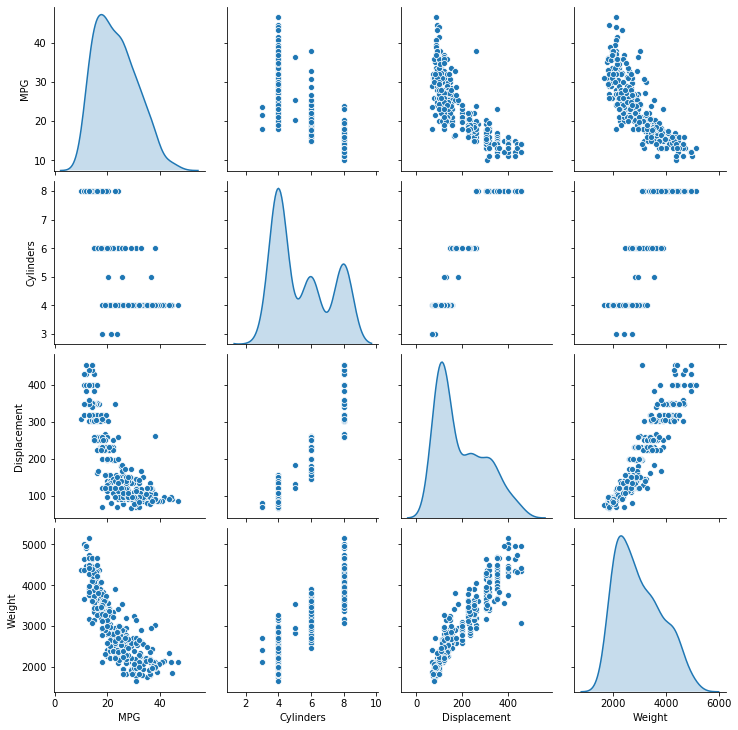

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics.

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value, or _label_ , from the _features_. Roughly speaking, the _features_ are the inputs to an ANN, and the _label_ is the output. The _label_ is the value that you will train the ANN model to predict.

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

**Exercise**: Train an ANN model identical to the one below on non-normalized data and compare its performance to a model that has been trained on normalized data.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Note: This is one way to normalize the data.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build an ANN model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

There is a variety of options, even for the most basic ANN that is being constructed here. Some options to investigate include:
* The number of nodes (aka neurons), here `64`;
* The activation function, here `relu`;
* `Dense` layers versus its alternatives;
* `Sequential` model versus its alternatives;
* The chosen optimizer, here `RMSprop`;
* The loss function, here `mse`;
* The performance metrics, here `mae` and `mse`.

In [20]:
train_dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [31]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

Note: Warnings may show in the output of the model build. In testing this notebook, this has not impaired the functioning of the notebook code.

In [50]:
model = build_model()
model2 = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [51]:
model.summary()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20

So far, the model has been _built,_ but it has not been _trained_. In other words, the structure of the ANN model has been set, but the model has not been confronted with data which it will attempt to mimic (ie. predict). All the parameters in the ANN model are currently random.


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [52]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result
#example_batch2 = train_dataset[:10]
#example_result2 = model2.predict(example_batch2)
#example_result2

array([[ 0.04133874],
       [ 0.12475829],
       [ 0.20018674],
       [ 0.28655037],
       [ 0.21782157],
       [ 0.1802173 ],
       [ 0.19526139],
       [ 0.1011458 ],
       [-0.10967472],
       [ 0.01106355]], dtype=float32)

The mechanics of the model seems to be working, and it produces a result of the expected shape and type. However, it is, in all likelihood, a very poor predictor of the value of the _label_ given an input of particular _features_.

### Train the model

Train the model for `10` epochs, and record the training and validation accuracy in the `history` object.

In [53]:
EPOCHS = 10

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

### Plot the history

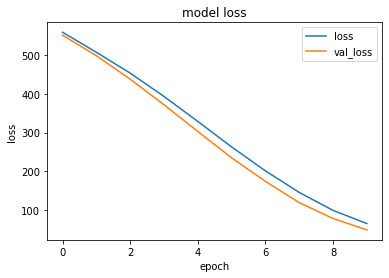

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

`10` epochs may be too few, so try training for more epochs.

### Train the model

Train the model for `1000` epochs, and record the training and validation accuracy in the `history` object.

In [55]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

Examine the model's training progress using the stats stored in the `history` object.

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.570680,1.031938,2.570680,8.590962,2.227173,8.590961,995
996,2.412099,0.972321,2.412098,8.919795,2.267719,8.919795,996
997,2.523983,1.029752,2.523983,8.635976,2.228215,8.635977,997
998,2.558572,0.987787,2.558572,8.571736,2.231151,8.571735,998
999,2.608726,0.989632,2.608727,8.690102,2.214851,8.690103,999


#### Plot the mean absolute error through the epochs of the training history

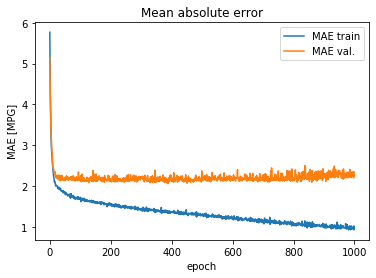

In [22]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
#plt.ylim([0,10])
plt.title('Mean absolute error')
plt.ylabel('MAE [MPG]')
plt.xlabel('epoch')
plt.legend(['MAE train','MAE val.'],loc='upper right')
plt.show()

Try smoothing the plot to better visualize the trend.

#### Plot the mean squared error through the epochs of the training history

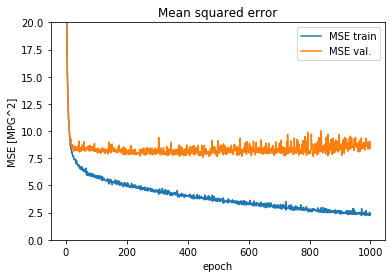

In [23]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.ylim([0,20])
plt.title('Mean squared error')
plt.ylabel('MSE [MPG^2]')
plt.xlabel('epoch')
plt.legend(['MSE train','MSE val.'],loc='upper right')
plt.show()

Again, try smoothing the plot to better visualize the trend.

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

##### The `EarlyStopping` functionality is not currently working in what follows, so the plot has been manually truncated.

In [57]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

###### Note: The functionality of the original file as been altered (omitting `callbacks`) as described below.

• The `tensorflow_docs` package is needed (in the `callbacks` argument), but that has not been installed in the environment. If it had, the `early_history` fit of the model would have been:
```
early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
```

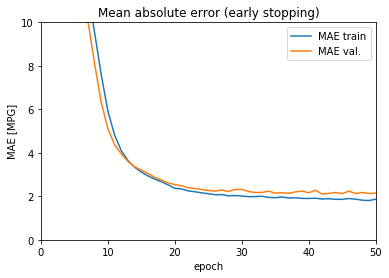

In [25]:
plt.plot(early_history.history['mean_absolute_error'])
plt.plot(early_history.history['val_mean_absolute_error'])
plt.xlim([0,50]) # Plot manually truncated here
plt.ylim([0,10])
plt.title('Mean absolute error (early stopping)')
plt.ylabel('MAE [MPG]')
plt.xlabel('epoch')
plt.legend(['MAE train','MAE val.'],loc='upper right')
plt.show()

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

 - 0s - loss: 6.6948 - mean_absolute_error: 2.0472 - mean_squared_error: 6.6948
Testing set Mean Abs Error:  2.05 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

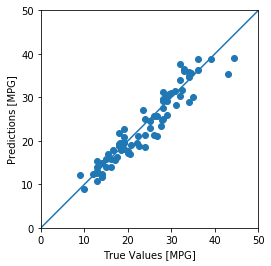

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

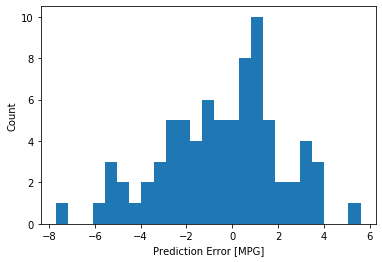

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not strictly gaussian, but we might expect that because the number of samples is relatively small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
  - Which other loss functions are available? When would you use them?
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
  - Which other evaluation metrics are available? When would you use them?
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

____

## Copyright & license details

##### Copyright 2018 The TensorFlow Authors.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View original notebook on TensorFlow.org</a>
  </td>
</table>

In [29]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [30]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.